# Outline
1. EDA
2. Deal with missing value
3. Feature engineering
4. Preprocessing
5. Model training
6. Evaluation
7. Prediction

# Libraries

In [252]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import silhouette_score
import h2o
from h2o.estimators import H2OExtendedIsolationForestEstimator

# Helper functions

In [253]:
# show the missing value percentage for features
def missing_value_percentage(df):
    total = df.isnull().sum().sort_values(ascending=False)
    percentage = (df.isnull().sum() / len(df)).sort_values(ascending=False) * 100
    percentage_str = percentage.map('{:.2f}%'.format)
    missing_data = pd.concat([total, percentage_str], axis=1, keys=['Total', 'Percentage'])
    missing_data = missing_data[total > 0]

    return missing_data

In [288]:
def evaluation(df, column, score):
    df["anomaly_transform"] = np.where(df[column]>score, 1, 0)
    nonmatch = df[df["loan_status"] != df["anomaly_transform"]].id.nunique()
    match = df[df["loan_status"] == df["anomaly_transform"]].id.nunique()

    accuracy = match/(match+nonmatch)

    return print(f"accuracy: '{accuracy:.2%}'")

In [255]:
def random_select(df, target, features):
    selection = df[target].sample(n=1).iloc[0]
    df_selected = df[df[target] == selection][[target] + features]
    return df_selected

# Data load and descrption

In [256]:
data = pd.read_csv("credit_risk_dataset.csv")

| Feature Name                  | Description                                |
|-------------------------------|--------------------------------------------|
| `person_age`                  | Age                                        |
| `person_income`               | Annual Income                              |
| `person_home_ownership`       | Home ownership                             |
| `person_emp_length`           | Employment length (in years)               |
| `loan_intent`                 | Loan intent                                |
| `loan_grade`                  | Loan grade                                 |
| `loan_amnt`                   | Loan amount                                |
| `loan_int_rate`               | Interest rate                              |
| `loan_status`                 | Loan status (0 is non default 1 is default)|
| `loan_percent_income`         | Percent income                             |
| `cb_person_default_on_file`   | Historical default                         |
| `cb_preson_cred_hist_length`  | Credit history length                      |


# EDA

In [257]:
data

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4
...,...,...,...,...,...,...,...,...,...,...,...,...
32576,57,53000,MORTGAGE,1.0,PERSONAL,C,5800,13.16,0,0.11,N,30
32577,54,120000,MORTGAGE,4.0,PERSONAL,A,17625,7.49,0,0.15,N,19
32578,65,76000,RENT,3.0,HOMEIMPROVEMENT,B,35000,10.99,1,0.46,N,28
32579,56,150000,MORTGAGE,5.0,PERSONAL,B,15000,11.48,0,0.10,N,26


In [258]:
data.describe()

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_cred_hist_length
count,32581.000000,3.258100e+04,31686.000000,32581.000000,29465.000000,32581.000000,32581.000000,32581.000000
mean,27.734600,6.607485e+04,4.789686,9589.371106,11.011695,0.218164,0.170203,5.804211
std,6.348078,6.198312e+04,4.142630,6322.086646,3.240459,0.413006,0.106782,4.055001
min,20.000000,4.000000e+03,0.000000,500.000000,5.420000,0.000000,0.000000,2.000000
25%,23.000000,3.850000e+04,2.000000,5000.000000,7.900000,0.000000,0.090000,3.000000
50%,26.000000,5.500000e+04,4.000000,8000.000000,10.990000,0.000000,0.150000,4.000000
75%,30.000000,7.920000e+04,7.000000,12200.000000,13.470000,0.000000,0.230000,8.000000
max,144.000000,6.000000e+06,123.000000,35000.000000,23.220000,1.000000,0.830000,30.000000


In [259]:
features = data.columns.drop(["loan_status"])

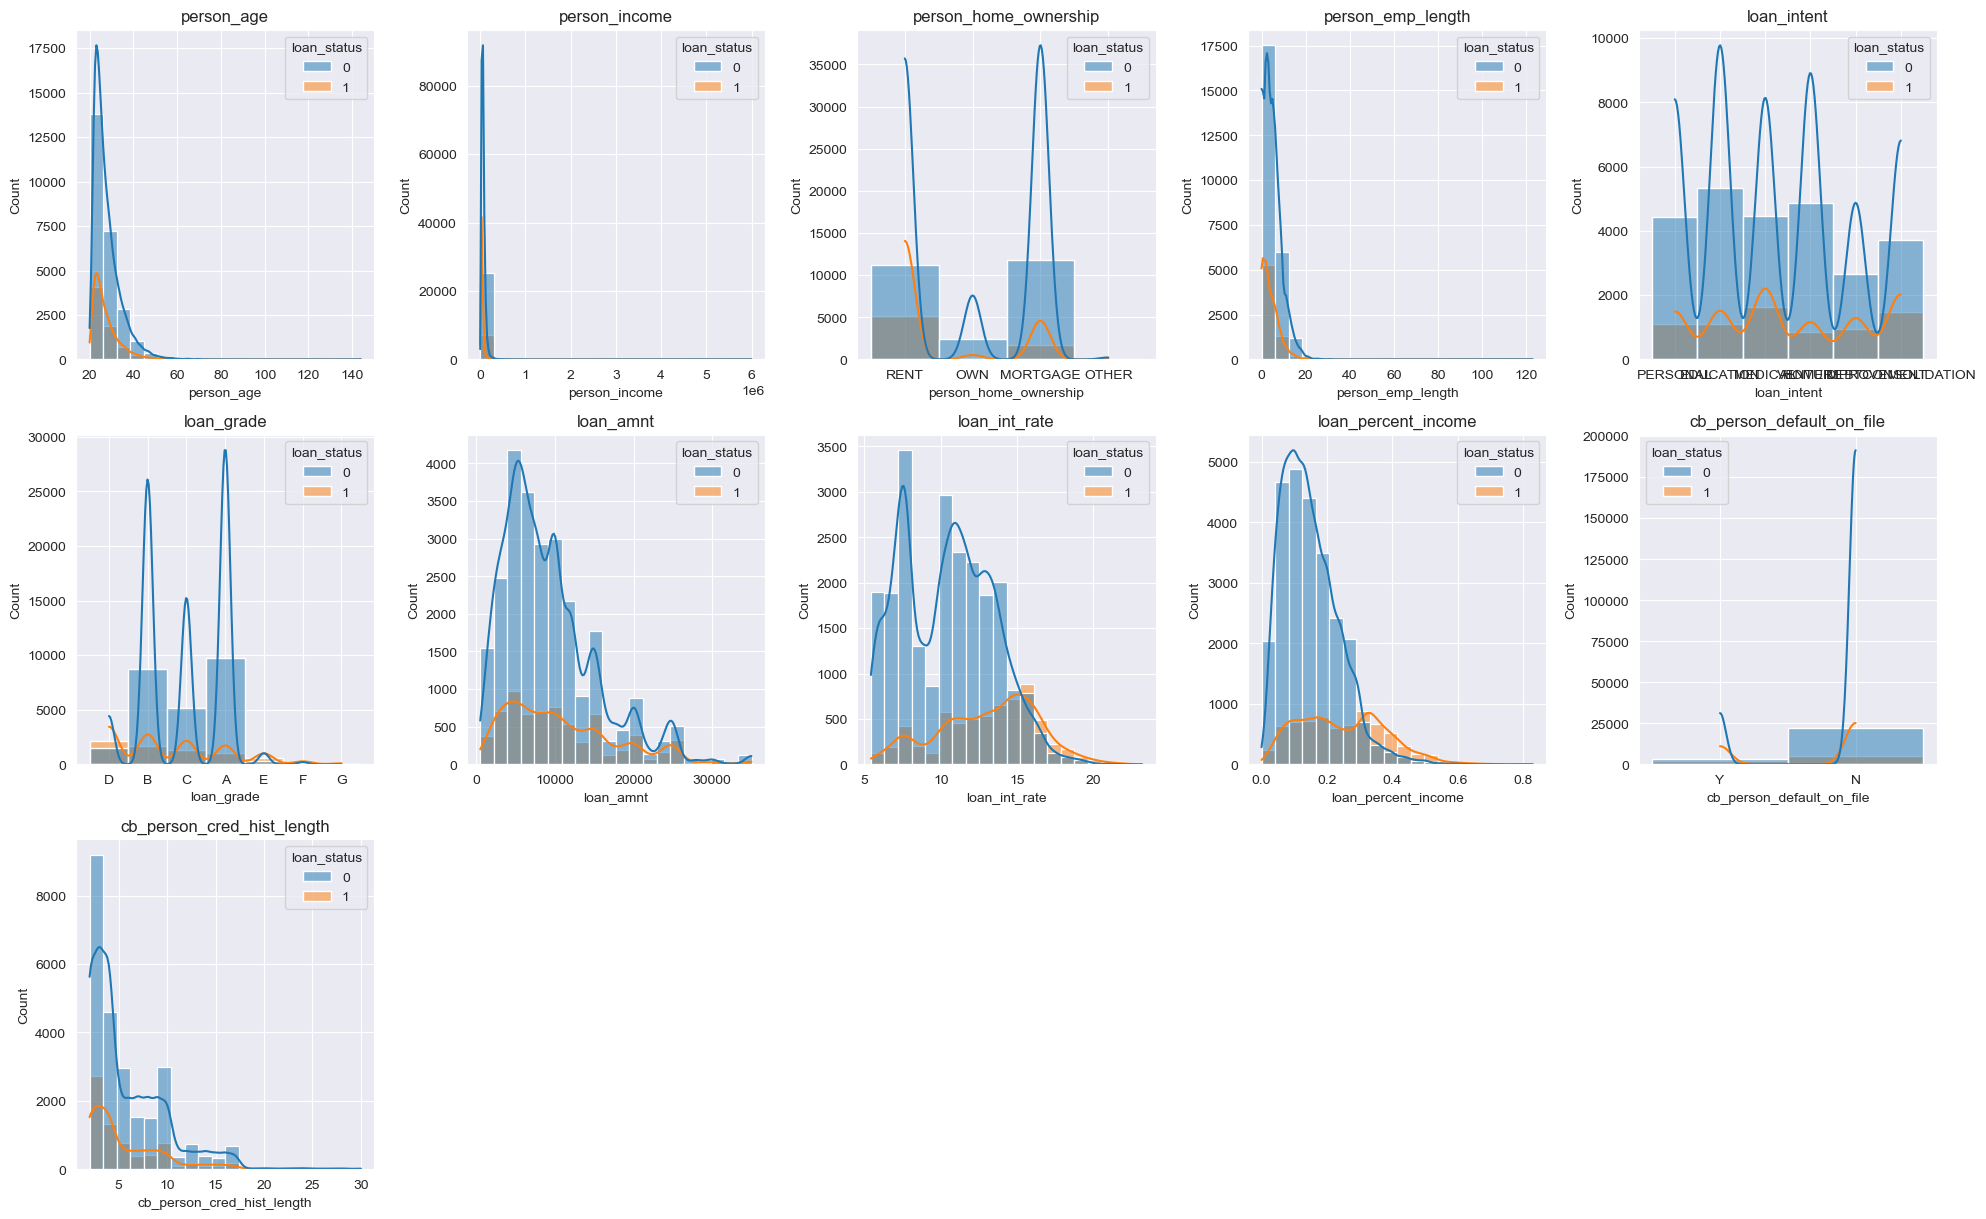

In [260]:
features = data.columns.drop(["loan_status"])
feature_data = data[features]

fig = plt.figure(figsize=(20, 20))

for idx, val in enumerate(features):
    ax = fig.add_subplot(5, 5, idx + 1)
    sns.histplot(data=data, x=val, axes=ax, bins=20, hue='loan_status', kde=True)
    ax.set_title(val)

plt.tight_layout()
plt.show()

<Axes: >

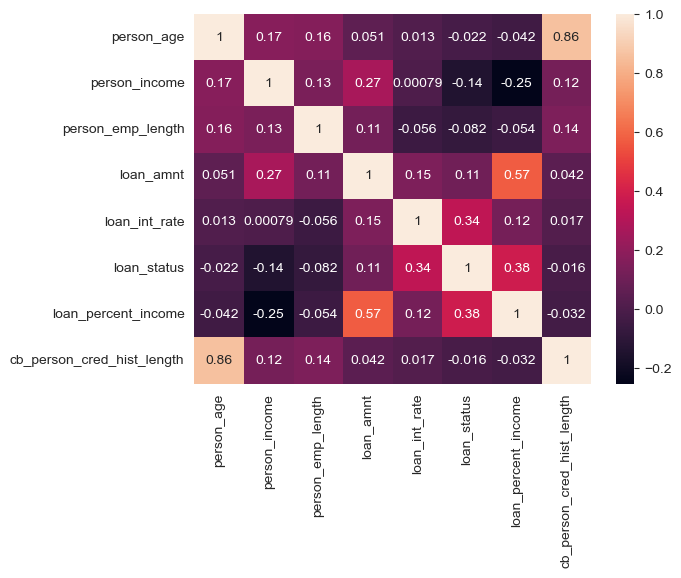

In [261]:
numerical_features = [col for col in data.columns if data[col].dtype in ["float64", "int64"]]
corr_matrix = data[numerical_features].corr()
sns.heatmap(corr_matrix, annot=True)

# Dealing with missing values

In [262]:
missing_value_percentage(data)

,Total,Percentage
loan_int_rate,3116,9.56%
person_emp_length,895,2.75%


- No high relation columns with loand_int_rate and person_emp_length, so we would use other columns to impute missing values.
- Instead, using mean/median/mode to impute

In [263]:
def imputation(df, column, strategy):
    df_copy = df.copy()
    imputer = SimpleImputer(missing_values=np.nan, strategy=strategy)

    df_copy[[column]] = imputer.fit_transform(df_copy[[column]])

    return df_copy

In [264]:
data = imputation(data, 'loan_int_rate', 'median')
data = imputation(data, 'person_emp_length', 'median')

In [265]:
missing_value_percentage(data)

,Total,Percentage


# Preprocessing

(scaling, normalization, skewness, imbalance)

## Scaling

In [266]:
def scaling(df, numerical_features):
    selected_features = numerical_features.remove('loan_status')
    scaler = StandardScaler()
    df[numerical_features] = scaler.fit_transform(df[numerical_features])

    return df

In [267]:
numerical_features

['person_age',
 'person_income',
 'person_emp_length',
 'loan_amnt',
 'loan_int_rate',
 'loan_status',
 'loan_percent_income',
 'cb_person_cred_hist_length']

In [268]:
data = scaling(data, numerical_features)

In [269]:
data.describe()

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_cred_hist_length
count,32581.000000,3.258100e+04,3.258100e+04,3.258100e+04,3.258100e+04,32581.000000,3.258100e+04,3.258100e+04
mean,0.000000,5.582976e-17,2.791488e-17,-5.582976e-17,3.258190e-16,0.218164,-2.582126e-16,-5.582976e-17
std,1.000015,1.000015e+00,1.000015e+00,1.000015e+00,1.000015e+00,0.413006,1.000015e+00,1.000015e+00
min,-1.218435,-1.001495e+00,-1.166536e+00,-1.437739e+00,-1.813891e+00,0.000000,-1.593962e+00,-9.381673e-01
25%,-0.745843,-4.448836e-01,-6.772166e-01,-7.259378e-01,-8.176433e-01,0.000000,-7.511089e-01,-6.915544e-01
50%,-0.273252,-1.786780e-01,-1.878971e-01,-2.514036e-01,-6.366905e-03,0.000000,-1.892065e-01,-4.449416e-01
75%,0.356869,2.117569e-01,5.460821e-01,4.129442e-01,6.815955e-01,0.000000,5.599966e-01,5.415097e-01
max,18.315335,9.573601e+01,2.892661e+01,4.019404e+00,3.962397e+00,1.000000,6.179020e+00,5.966992e+00


# Encoding

In [270]:
data.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,-0.903374,-0.114143,RENT,28.926614,PERSONAL,D,4.019404,1.625921,1,3.931411,Y,-0.691554
1,-1.060904,-0.911147,OWN,0.056763,EDUCATION,B,-1.358650,0.042310,0,-0.657458,N,-0.938167
2,-0.430783,-0.911147,MORTGAGE,-0.921876,MEDICAL,C,-0.646849,0.603713,1,3.744110,N,-0.691554
3,-0.745843,-0.009274,RENT,-0.187897,MEDICAL,C,4.019404,1.369558,1,3.369508,N,-0.938167
4,-0.588313,-0.188358,RENT,0.790742,MEDICAL,C,4.019404,1.058028,1,3.556809,Y,-0.444942


In [271]:
data.groupby(["person_home_ownership"]).size()

person_home_ownership
MORTGAGE    13444
OTHER         107
OWN          2584
RENT        16446
dtype: int64

In [272]:
data["person_home_ownership"] = np.where(
    data["person_home_ownership"] == "OWN", 0, np.where(
        data["person_home_ownership"] == "RENT", 1, np.where(
            data["person_home_ownership"] == "MORTGAGE",2, 3
        )
    )
)

In [273]:
def encoding(df):
    categorical_features = [col for col in df.columns if df[col].dtype == "object"]

    high_cardinality = [col for col in categorical_features if df[col].nunique() > 2]
    low_cardinality = [col for col in categorical_features if col not in high_cardinality]

    df_dummies = pd.DataFrame()
    for col in high_cardinality:
        dummies = pd.get_dummies(df[col])

        df_dummies = pd.concat([df_dummies, dummies], axis=1)

    df = df.drop(high_cardinality, axis=1)
    df_new = pd.concat([df, df_dummies], axis=1)

    encoder = OrdinalEncoder()

    df_new[low_cardinality] = encoder.fit_transform(df_new[low_cardinality])

    return df_new

In [274]:
data_encoded = encoding(data)
data_encoded

,person_age,person_income,person_home_ownership,person_emp_length,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,...,MEDICAL,PERSONAL,VENTURE,A,B,C,D,E,F,G
0,-0.903374,-0.114143,1,28.926614,4.019404,1.625921,1,3.931411,1.0,-0.691554,...,0,1,0,0,0,0,1,0,0,0
1,-1.060904,-0.911147,0,0.056763,-1.358650,0.042310,0,-0.657458,0.0,-0.938167,...,0,0,0,0,1,0,0,0,0,0
2,-0.430783,-0.911147,2,-0.921876,-0.646849,0.603713,1,3.744110,0.0,-0.691554,...,1,0,0,0,0,1,0,0,0,0
3,-0.745843,-0.009274,1,-0.187897,4.019404,1.369558,1,3.369508,0.0,-0.938167,...,1,0,0,0,0,1,0,0,0,0
4,-0.588313,-0.188358,1,0.790742,4.019404,1.058028,1,3.556809,1.0,-0.444942,...,1,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32576,4.610190,-0.210945,2,-0.921876,-0.599395,0.697821,0,-0.563808,0.0,5.966992,...,0,1,0,0,0,1,0,0,0,0
32577,4.137599,0.870011,2,-0.187897,1.271060,-1.142154,0,-0.189207,0.0,3.254251,...,0,1,0,1,0,0,0,0,0,0
32578,5.870433,0.160129,1,-0.432557,4.019404,-0.006367,1,2.713956,0.0,5.473767,...,0,0,0,0,1,0,0,0,0,0
32579,4.452660,1.354021,2,0.056763,0.855843,0.152643,0,-0.657458,0.0,4.980541,...,0,1,0,0,1,0,0,0,0,0


# Model training

In [275]:
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O_cluster_uptime:,39 mins 11 secs
H2O_cluster_timezone:,Asia/Taipei
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.42.0.2
H2O_cluster_version_age:,13 hours and 16 minutes
H2O_cluster_name:,H2O_from_python_Sean_oty66g
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.280 Gb
H2O_cluster_total_cores:,6
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


In [276]:
data_encoded["id"] = data_encoded.index + 1
target = data_encoded[["id", "loan_status"]]
train = data_encoded.drop(["loan_status"], axis=1).copy()

In [339]:
col_lst = [col for col in train.columns]

In [340]:
eif = H2OExtendedIsolationForestEstimator(model_id="eif.hex", ntrees=100, sample_size=1000, extension_level=len(train.columns)-3)

In [341]:
train_frame = h2o.H2OFrame(train)
eif.train(x=col_lst, training_frame=train_frame)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
extendedisolationforest Model Build progress: |██████████████████████████████████| (done) 100%


,number_of_trees,size_of_subsample,extension_level,seed,number_of_trained_trees,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves,min_isolated_point,max_isolated_point,mean_isolated_point,min_not_isolated_point,max_not_isolated_point,mean_not_isolated_point,min_zero_splits,max_zero_splits,mean_zero_splits
,100,1000,20,2582936072783059456.0000000,100.0,9.0,9.0,9.0,93.0,307.0,215.68,37.0,159.0,102.65,841.0,963.0,897.35,6.0,33.0,18.78


In [342]:
eif_result = eif.predict(train_frame)

extendedisolationforest prediction progress: |███████████████████████████████████| (done) 100%


In [343]:
df_eif_result = eif_result['anomaly_score'].as_data_frame()

In [344]:
df_final = pd.concat([data_encoded, df_eif_result], axis=1)

In [345]:
evaluation(df_final, 'anomaly_score', 0.6)

accuracy: '78.02%'
